<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a flow chart to help one make decisions based on the possible outcomes. It works by splitting data into branches based on conditions, leading to final answers at the leaf nodes.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The "depth" of a decision tree is the longest path from the root to a leaf, showing how many splits or questions it asks. A tree is too deep if it overfits noisy details, or not deep enough if it misses key patterns

**Task4:**

How are BART models similar and different from a decision tree?

BART uses many small trees combined for flexibility, while a single decision tree relies on one structured path. BART handles uncertainty with probabilities and excels in complex data, whereas decision trees are simpler but can overfit

**Task5**:

Why would we use a BART model instead of a decision tree?

We’d use a BART model over a decision tree because it combines multiple trees to reduce overfitting, captures complex patterns better, and provides uncertainty estimates

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [5]:
!pip install pymc-bart
!pip install preliz

  Using cached preliz-0.16.0-py3-none-any.whl.metadata (6.1 kB)
Using cached preliz-0.16.0-py3-none-any.whl (519 kB)


In [6]:
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [7]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [9]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


Output()

Output()

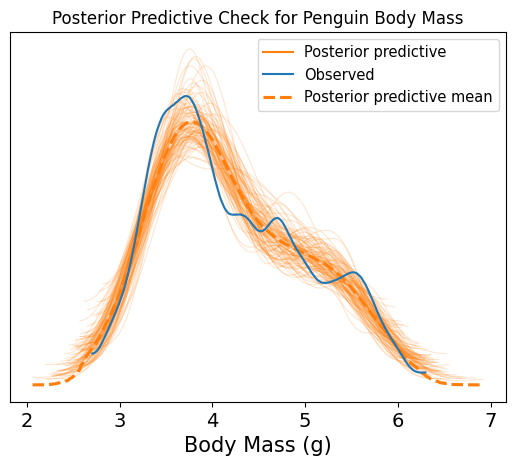

In [8]:
features = ["flipper_length", "bill_depth", "bill_length"]
X = penguins[features].to_numpy()
Y = penguins["body_mass"].to_numpy()

with pm.Model() as model_penguins:
    s = pm.HalfNormal("s", 500)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    y = pm.Normal("y", mu=μ_, sigma=s, observed=Y)
    idata_penguins = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata_penguins, model_penguins, extend_inferencedata=True)
#plot
ax = az.plot_ppc(idata_penguins, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_title("Posterior Predictive Check for Penguin Body Mass")
ax.set_xlabel("Body Mass (g)")
plt.show()

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

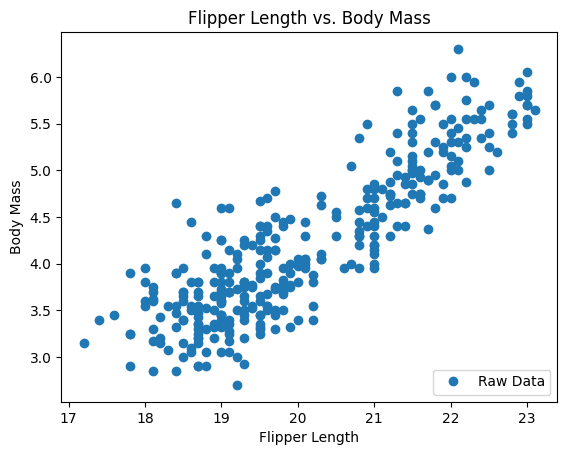

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


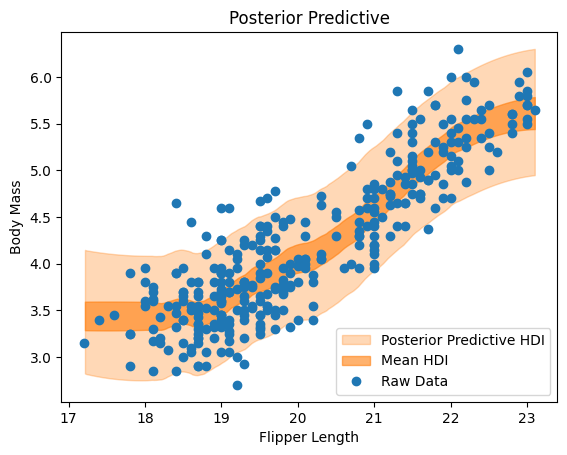

In [10]:
fig1, ax1 = plt.subplots()
ax1.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax1.set(
    title="Flipper Length vs. Body Mass",
    xlabel="Flipper Length",
    ylabel="Body Mass",
)
ax1.legend(loc="lower right")
plt.show()

posterior_mean = idata_penguins.posterior["μ_"]
pps = az.extract(idata_penguins, group="posterior_predictive", var_names=["y"]).T
idx = np.argsort(X[:, 0])  # Sort by flipper length

fig2, ax2 = plt.subplots()
az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax2,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)
az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax2,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax2.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax2.legend(loc="lower right")
ax2.set(
    title="Posterior Predictive",
    xlabel="Flipper Length",
    ylabel="Body Mass",
)
plt.show()

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think that the plot does a pretty good job at capturing the true association between flipper length and body mass in penguins. the majority of the raw data dots are within the predicted area and although there are a few outliers, I believe that those are moreso due to nature and penguin biology rather than code.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

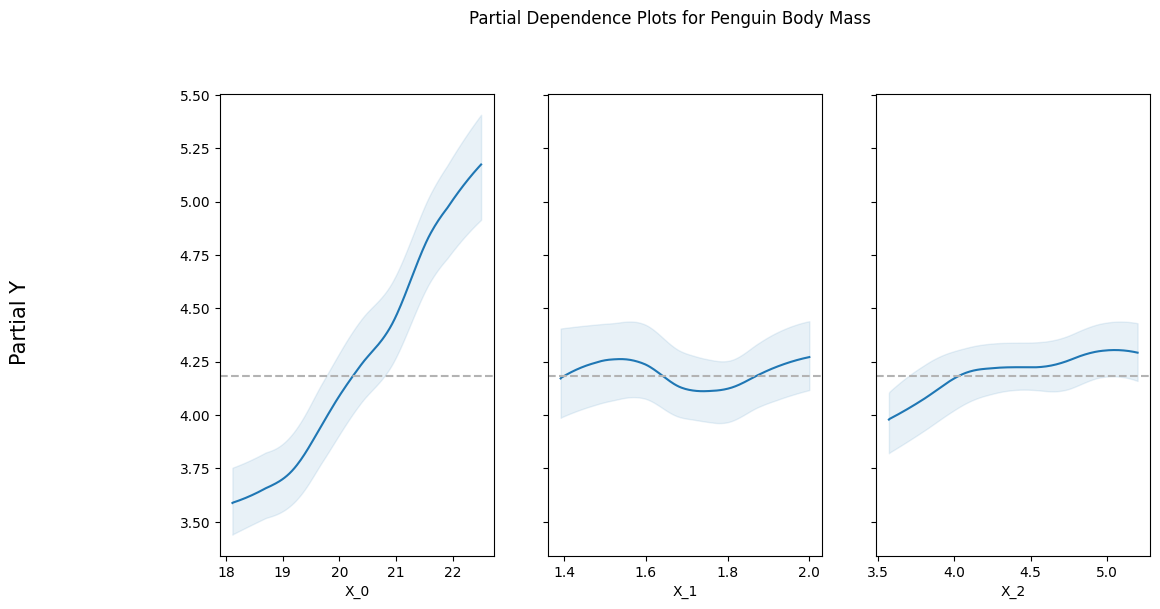

In [12]:
# Partial Dependence Plots (PDPs)
pmb.plot_pdp(μ_, X, Y, grid=(1, 3), figsize=(12, 6))
plt.suptitle("Partial Dependence Plots for Penguin Body Mass", y=1.02)
plt.show()

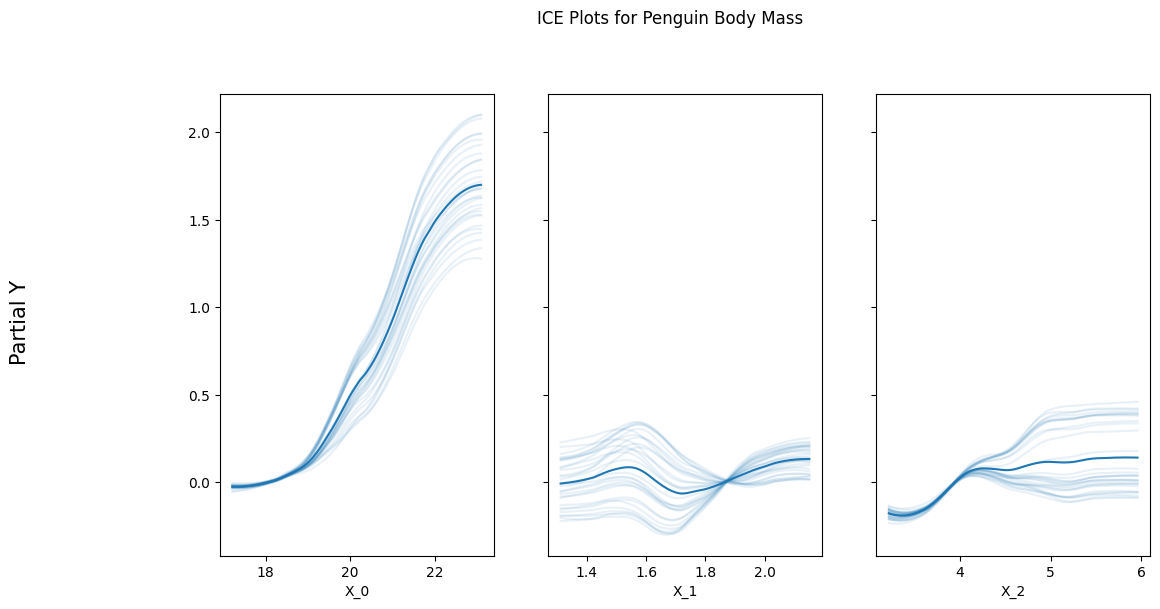

In [13]:
# Individual Conditional Expectation (ICE) Plots
pmb.plot_ice(μ_, X, Y, grid=(1, 3), figsize=(12, 6))
plt.suptitle("ICE Plots for Penguin Body Mass", y=1.02)
plt.show()

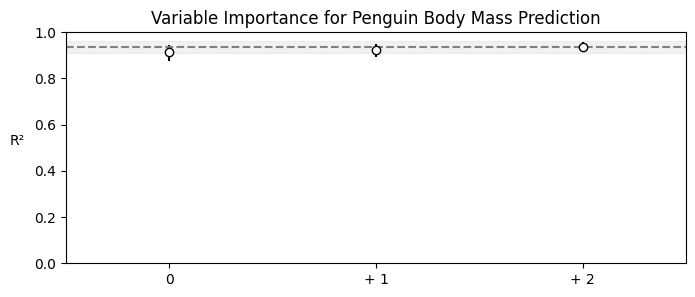

In [14]:
# Variable Importance Plot
vi_penguins = pmb.compute_variable_importance(idata_penguins, μ_, X)
pmb.plot_variable_importance(vi_penguins)
plt.title("Variable Importance for Penguin Body Mass Prediction")
plt.show()

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

overall, the factors dont seem to differ by such a large amount in the variable importance plot. Bill length (X2) narrowly leads as the most important predictor, i think this due to its slightly taller importance bar, with a steady positive link to body mass. Flipper length (X0) is a close second, its strong positive relationship complicated by interactions which is shown by the tight-to-spreading ICE lines, suggesting its effect depends on bill metrics. Bill depth (X1) trails, with a weaker, interaction-heavy role.